# City Couriers Fleet Churn Report

# Machine-Learning Model Report

Author: Guilherme Fernandes Ribeiro

# Executive Summary

<li>From the 20 possible features in the dataset, 9 were selected for the training phase.</li><br><br>

<li>The SVM algorithm was selected among all the classification algorithm tested.</li><br><br>

<li>The SVM algorithm was the best in accuracy (77.17%), kappa (0.54) and false-negative metrics.</li><br><br>

# Machine-Learning Model

This report uses 3 private python libraries written by the author called "courier_data_manager", "data_visualization_util" and "modeling_helper". All the documentation needed is inside the libraries script files that can be found in the "scripts" folder of this project.

In [1]:
#Importing libraries

import pandas as pd
import numpy as np
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

import courier_data_manager as cdm
import data_visualization_util as dvu
import modeling_helper as mh

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

# Loading the data

In [2]:
courier_life_data_path = "../datasets/Courier_lifetime_data.csv"
courier_weekly_data_path = "../datasets/Courier_weekly_data.csv"

courier_life_data = pd.read_csv(courier_life_data_path, header = 0, index_col = 0)
courier_weekly_data = pd.read_csv(courier_weekly_data_path, header = 0)

In [3]:
#Constants
churnWeeks = [9, 10, 11]
weeksToRemove = [8, 9, 10, 11]

# Prepare data for modeling

To prepare the data for the training phase, a few steps were made for processing the courier's lifetime and courier's weekly activity data.

First, all the couriers present in the "courier_lifetime_data.csv" were labeled as 'Not Churned' or 'Churned' by checking if the courier had any activity in the churn window (weeks 9, 10 and 11).

After labeling, the weeks 8, 9, 10 and 11 were removed from the "courier_weekly_data.csv" dataset. Remaining only the weeks from 0 to 7, which are the period of analysis.

Then, the feature 'weeks_worked' was created by counting how many weeks each courier has worked during the period of analysis.

Since the weekly activity dataset could have many rows for each courier, in order to make a classification regarding the courier's activity for the following weeks, is necessary to summarize the data.
For the summarizing strategy for this modeling, all the data of each courier was summed up. Since the majority of the features are unknown, summing makes more sense than any other aggregation function.

After summarize, the column 'week' was dropped. Since it has no meaning after being summarized.

The categorical 'feature_1' from the "courier_lifetime_data" was transformed to numerical and added to the dataset.

In the end, the label column was added.

It is also possible to check the function 'prepare_data_for_modeling' inside the "courier_data_manager" library for better technical understanding.

In [4]:
data_modeling = cdm.prepare_data_for_modeling(courier_life_data, courier_weekly_data, weeksToRemove, churnWeeks)

## Correlation matrix

The correlation matrix was calculated to check possible collinearity between the features in the dataset.

A pairwise visualization of the highest values is shown below.

In [5]:
corrMatrix = data_modeling.corr()
pairWiseCorrMatrix = dvu.pairwiseCorr(corrMatrix)
attr1 = pairWiseCorrMatrix['Attribute_1']
attr2 = pairWiseCorrMatrix['Attribute_2']

print(pairWiseCorrMatrix[pairWiseCorrMatrix.Value >= 0.85])

      Attribute_1 Attribute_2     Value
159  weeks_worked   feature_6  0.994574
158  weeks_worked   feature_5  0.994103
20      feature_6   feature_5  0.990100
71     feature_12   feature_5  0.986565
165  weeks_worked  feature_12  0.984803
100    feature_14   feature_9  0.984373
72     feature_12   feature_6  0.979649
41      feature_9   feature_5  0.979005
50     feature_10   feature_5  0.968638
58     feature_11   feature_3  0.967222
42      feature_9   feature_6  0.965971
163  weeks_worked  feature_10  0.965484
162  weeks_worked   feature_9  0.965375
75     feature_12   feature_9  0.960157
76     feature_12  feature_10  0.959328
96     feature_14   feature_5  0.958835
51     feature_10   feature_6  0.956634
166  weeks_worked  feature_13  0.955251
90     feature_13  feature_12  0.955069
84     feature_13   feature_6  0.950983
97     feature_14   feature_6  0.950579
167  weeks_worked  feature_14  0.949864
54     feature_10   feature_9  0.947150
83     feature_13   feature_5  0.946756


## Selecting the dependent and independent variable

In [6]:
dataFeatures = data_modeling.drop('churned', axis = 1)
dataTarget = data_modeling.loc[:, 'churned']

## Spliting into training and test set

For this report, the dataset was split as follows: 70% for the training set and 30% for the test set.
As the dataset does not have many rows, there is no need to sample the data for speed the training time up.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(dataFeatures, dataTarget, 
                                                    stratify = dataTarget, test_size = 0.3, random_state = 0)

## Base model

To have an idea of how this dataset behaves, an out-of-the-shelf model was built.
By building a random forest model, we can check for the importance of the variables after the training for future feature selection phase.

In [8]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 123)

In [9]:
rfCVScore = mh.cvScores(rf, x_train, y_train, 5)
print(rfCVScore)

    CV-Mean     CV-Sd
0  0.733333  0.032457


In [10]:
# Fitting models
rf = rf.fit(x_train, y_train)

In [11]:
rfPrediction, accuracy_rf, kappa_rf = mh.classif_predict_metric(rf, x_test, y_test)
print('Random Forest accuracy: %.6f' % accuracy_rf)
print('Random Forest kappa: %.6f' % kappa_rf)

Random Forest accuracy: 0.730594
Random Forest kappa: 0.461378


## Variables Importance

In the following table is possible to see the most important variables for the random forest classification model.

In [12]:
var_imp = pd.DataFrame({'Variable' : data_modeling.drop('churned', axis = 1).columns, 
                        'Score' : rf.feature_importances_})

var_imp.sort_values('Score', ascending = False)

,Variable,Score
11,feature_11,0.082327
3,feature_3,0.077460
5,feature_5,0.076364
9,feature_9,0.075961
2,feature_2,0.073836
14,feature_14,0.071280
1,feature_1,0.068180
6,feature_6,0.055148
10,feature_10,0.054454
0,courier,0.047751


## Feature Selection

As a feature selection strategy, the most important variables in the table above were selected and those who have high collinearity among each other were discarded.

Then, the features selected were: 'feature_11', 'feature_5', 'feature_9', 'feature_1', 'courier', 'feature_7', 'feature_17', 'feature_8' and 'feature_4'

It is interesting to notice that the courier column has uncommon importance and was selected. Something unusual for an identification feature. From the Exploratory Analysis Report, we learned that the couriers have a high churn rate. Which we can infer that the couriers which are new to the job are more likely to continue working for the next following weeks rather than the old couriers. So, assuming the courier's id is sequential, the newer the courier, the higher is the id. Therefore, a high identification number could mean that the courier is new, which can be a good way to decide if this courier will churn or not.

In [13]:
#Features to remove from the dataset
features_to_remove = ['feature_2', 'feature_3', 'feature_6', 'feature_10', 'feature_12', 'feature_13', 'feature_14', 
                      'feature_15', 'feature_16', 'weeks_worked', 'life_feature_1']

In [14]:
x_train_fs = mh.featureSelection(x_train, features_to_remove)
x_test_fs = mh.featureSelection(x_test, features_to_remove)

## Checking base model after feature selection

In [15]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 123)
rf_fs_CVScore = mh.cvScores(rf, x_train_fs, y_train, 5)
print(rf_fs_CVScore)

    CV-Mean    CV-Sd
0  0.739216  0.04047


In [16]:
# Fitting models
rf = rf.fit(x_train_fs, y_train)

In [17]:
rf_fs_Prediction, accuracy_rf_fs, kappa_rf_fs = mh.classif_predict_metric(rf, x_test_fs, y_test)
print('Random Forest accuracy: %.6f' % accuracy_rf_fs)
print('Random Forest kappa: %.6f' % kappa_rf_fs)

Random Forest accuracy: 0.712329
Random Forest kappa: 0.424670


# Hyperparameters Tuning

The strategy for the hyperparameters tuning phase is the following:

For each algorithm, we create a large set of possible values for each tuning parameter. In the universe of possible combination of these values, randomly, we sample a small set of values and train the algorithm with them. Using a score function, we select the parameters that performed the highest score among all the other parameters sampled. This step gives us an idea of where are the best parameters for this modeling.

After having the best parameters from the random search, we create a small set of possible values near each parameter selected in the previous phase. Run the model using all the possible parameters combinations and select the ones that gave us the best score regarding the score function.

For simplicity, this work has used the score function built-in inside each algorithm.

For parametric algorithms, the dataset was standardized in order to make them work properly.

In [18]:
# Standardization of data
x_train_fs_std = mh.featureStandardization(x_train_fs)
x_test_fs_std = mh.featureStandardization(x_test_fs)

The following sections show the hyperparameters tuning process.<br>
The algorithm selected to participate were: Random Forest, SVM, and K-NN.<br>
Another classification algorithm could have been used. However, to make this report shorter, we restricted to those 3 algorithms only.

## Random Forest

### Random Search

In [21]:
rf_params = {'n_estimators' : np.arange(100, 2000, 100), 
            'max_features' : np.arange(1, len(x_train_fs.columns) + 1, 1), 
            'max_depth' : np.arange(1, 25, 1)}
rf_default = RandomForestClassifier()

rf_rand_best_param = mh.performRandomSearch(rf_default, x_train_fs, y_train, rf_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished


In [22]:
rf_rand_best_param

{'n_estimators': 1000, 'max_features': 3, 'max_depth': 18}

#### Cross-validation Scores

In [23]:
rf_hyp = RandomForestClassifier(n_estimators = 1000, max_features = 3, max_depth = 18, n_jobs = -1, random_state = 123)
rf_hyp_CVScores = mh.cvScores(rf_hyp, x_train_fs, y_train, cv = 5)

In [24]:
rf_hyp_CVScores

,CV-Mean,CV-Sd
0,0.754902,0.0232


#### Predictions and Metrics

In [25]:
# Fitting model
rf_hyp = rf_hyp.fit(x_train_fs, y_train)

In [26]:
rf_hyp_Pred, accuracy_rf_hyp, kappa_rf_hyp = mh.classif_predict_metric(rf_hyp, x_test_fs, y_test)
print('Random Forest accuracy: %.6f' % accuracy_rf_hyp)
print('Random Forest kappa: %.6f' % kappa_rf_hyp)

Random Forest accuracy: 0.703196
Random Forest kappa: 0.406455


### Grid Search

In [27]:
rf_params = {'n_estimators' : np.arange(800, 1201, 50), 
            'max_features' : np.arange(1, 5, 1), 
            'max_depth' : np.arange(14, 23, 1)}
rf_default = RandomForestClassifier(random_state = 123)

rf_grid_best_param = mh.performGridSearch(rf_default, x_train_fs, y_train, rf_params)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 10.6min finished


In [28]:
rf_grid_best_param

{'max_depth': 14, 'max_features': 3, 'n_estimators': 800}

#### Cross-validation Scores

In [36]:
rf_hyp = RandomForestClassifier(n_estimators = 800, max_features = 3, max_depth = 14, n_jobs = -1, random_state = 123)
rf_hyp_CVScores = mh.cvScores(rf_hyp, x_train_fs, y_train, cv = 5)

In [37]:
rf_hyp_CVScores

,CV-Mean,CV-Sd
0,0.75098,0.031979


#### Predictions and Metrics

In [38]:
# Fitting model
rf_hyp = rf_hyp.fit(x_train_fs, y_train)

In [39]:
rf_hyp_Pred, accuracy_rf_hyp, kappa_rf_hyp = mh.classif_predict_metric(rf_hyp, x_test_fs, y_test)
print('Random Forest accuracy: %.6f' % accuracy_rf_hyp)
print('Random Forest kappa: %.6f' % kappa_rf_hyp)

Random Forest accuracy: 0.707763
Random Forest kappa: 0.415562


## SVM

### Random Search

In [40]:
svm_params = {'gamma' : list(10.0**exp for exp in np.arange(-10, 2, 1)), 
            'C' : np.arange(3, 8, 1), 
            'kernel' : ['linear', 'rbf', 'sigmoid', 'poly']}
svm_default = SVC(gamma = 'auto', random_state = 123)

svm_rand_best_param = mh.performRandomSearch(svm_default, x_train_fs_std, y_train, svm_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


In [41]:
svm_rand_best_param

{'kernel': 'rbf', 'gamma': 0.001, 'C': 7}

#### Cross-validation Scores

In [43]:
svm_hyp = SVC(gamma = 0.001, C = 7, kernel = 'rbf')
svm_hyp_CVScores = mh.cvScores(svm_hyp, x_train_fs_std, y_train, cv = 5)

In [44]:
svm_hyp_CVScores

,CV-Mean,CV-Sd
0,0.745098,0.027028


#### Predictions and Metrics

In [45]:
# Fitting model
svm_hyp = svm_hyp.fit(x_train_fs_std, y_train)

In [46]:
svm_hyp_pred, accuracy_svm_hyp, kappa_svm_hyp = mh.classif_predict_metric(svm_hyp, x_test_fs_std, y_test)

print("SVM Accuracy Score: %.6f" % accuracy_svm_hyp)
print("SVM Kappa Score: %.6f \n" % kappa_svm_hyp)

SVM Accuracy Score: 0.776256
SVM Kappa Score: 0.552782 



### Grid Search

In [47]:
svm_params = {'gamma' : list(10.0**exp for exp in np.arange(-5, 1, 1)), 
            'C' : np.arange(5, 11, 1), 
            'kernel' : ['linear', 'rbf', 'sigmoid', 'poly']}
svm_default = SVC(gamma = 'auto', random_state = 123)

svm_grid_best_param = mh.performGridSearch(svm_default, x_train_fs_std, y_train, svm_params)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   14.8s finished


In [48]:
svm_grid_best_param

{'C': 6, 'gamma': 0.001, 'kernel': 'rbf'}

#### Cross-validation Scores

In [50]:
svm_hyp = SVC(gamma = 0.001, C = 6, kernel = 'rbf')
svm_hyp_CVScores = mh.cvScores(svm_hyp, x_train_fs_std, y_train, cv = 5)

In [51]:
svm_hyp_CVScores

,CV-Mean,CV-Sd
0,0.745098,0.027028


#### Predictions and Metrics

In [52]:
# Fitting model
svm_hyp = svm_hyp.fit(x_train_fs_std, y_train)

In [53]:
svm_hyp_pred, accuracy_svm_hyp, kappa_svm_hyp = mh.classif_predict_metric(svm_hyp, x_test_fs_std, y_test)

print("SVM Accuracy Score: %.6f" % accuracy_svm_hyp)
print("SVM Kappa Score: %.6f \n" % kappa_svm_hyp)

SVM Accuracy Score: 0.771689
SVM Kappa Score: 0.543674 



## K-NN

### Random Search

In [54]:
knn_params = {'n_neighbors' : np.arange(3, 53, 2), 
             'weights' : ['uniform', 'distance'], 
             'algorithm' : ['ball_tree', 'kd_tree', 'brute']}
knn_default = KNeighborsClassifier()

knn_rand_best_param = mh.performRandomSearch(knn_default, x_train_fs_std, y_train, knn_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished


In [55]:
knn_rand_best_param

{'weights': 'uniform', 'n_neighbors': 25, 'algorithm': 'kd_tree'}

#### Cross-validation Scores

In [57]:
knn_hyp = KNeighborsClassifier(n_neighbors = 25, weights = 'uniform', algorithm = 'kd_tree', n_jobs = -1)
knn_hyp_CVScores = mh.cvScores(knn_hyp, x_train_fs_std, y_train, cv = 5)

In [58]:
knn_hyp_CVScores

,CV-Mean,CV-Sd
0,0.764706,0.038722


#### Predictions and Metrics

In [59]:
# Fitting model
knn_hyp = knn_hyp.fit(x_train_fs_std, y_train)

In [61]:
knn_hyp_pred, accuracy_knn_hyp, kappa_knn_hyp = mh.classif_predict_metric(knn_hyp, x_test_fs_std, y_test)

print("Random Forest Accuracy Score: %.6f" % accuracy_knn_hyp)
print("Random Forest Kappa Score: %.6f \n" % kappa_knn_hyp)

Random Forest Accuracy Score: 0.748858
Random Forest Kappa Score: 0.497811 



### Grid Search

In [62]:
knn_params = {'n_neighbors' : np.arange(7, 45, 2), 
             'weights' : ['uniform', 'distance'], 
             'algorithm' : ['ball_tree', 'kd_tree', 'brute']}
knn_default = KNeighborsClassifier()

knn_grid_best_param = mh.performGridSearch(knn_default, x_train_fs_std, y_train, knn_params)

Fitting 3 folds for each of 114 candidates, totalling 342 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    1.9s finished


In [63]:
knn_grid_best_param

{'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'uniform'}

#### Cross-validation Scores

In [64]:
knn_hyp = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', algorithm = 'ball_tree', n_jobs = -1)
knn_hyp_CVScores = mh.cvScores(knn_hyp, x_train_fs_std, y_train, cv = 5)

In [65]:
knn_hyp_CVScores

,CV-Mean,CV-Sd
0,0.758824,0.021118


#### Predictions and Metrics

In [66]:
# Fitting model
knn_hyp = knn_hyp.fit(x_train_fs_std, y_train)

In [67]:
knn_hyp_pred, accuracy_knn_hyp, kappa_knn_hyp = mh.classif_predict_metric(knn_hyp, x_test_fs_std, y_test)

print("Random Forest Accuracy Score: %.6f" % accuracy_knn_hyp)
print("Random Forest Kappa Score: %.6f \n" % kappa_knn_hyp)

Random Forest Accuracy Score: 0.726027
Random Forest Kappa Score: 0.452043 



# Results

## Accuracy and Kappa

In [68]:
accuracy = [accuracy_rf_hyp, accuracy_svm_hyp, accuracy_knn_hyp]
kappa = [kappa_rf_hyp, kappa_svm_hyp, kappa_knn_hyp]
algorithm = ['Random Forest', 'SVM', 'K-NN']

results = pd.DataFrame({'Accuracy' : accuracy, 'Kappa' : kappa}, index = algorithm)
results

,Accuracy,Kappa
Random Forest,0.707763,0.415562
SVM,0.771689,0.543674
K-NN,0.726027,0.452043


As we can see, the SVM performed the best accuracy (77.17%) and kappa value (0.5437)

## Confusion Matrix

To analyze the false-positives and false-negatives, the confusion matrix for each algorithm was calculated.

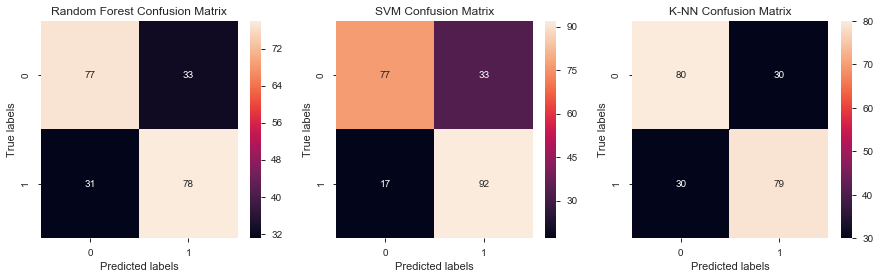

In [74]:
confusionMatrix_rf = confusion_matrix(y_test, rf_hyp_Pred)
confusionMatrix_svm = confusion_matrix(y_test, svm_hyp_pred)
confusionMatrix_knn = confusion_matrix(y_test, knn_hyp_pred)

fig, ax = plt.subplots(1, 3)

# labels and title
sns.heatmap(confusionMatrix_rf, annot = True, ax = ax[0], fmt = 'g');
ax[0].set_xlabel('Predicted labels');
ax[0].set_ylabel('True labels'); 
ax[0].set_title('Random Forest Confusion Matrix');

sns.heatmap(confusionMatrix_svm, annot = True, ax = ax[1], fmt = 'g');
ax[1].set_xlabel('Predicted labels');
ax[1].set_ylabel('True labels'); 
ax[1].set_title('SVM Confusion Matrix');

sns.heatmap(confusionMatrix_knn, annot = True, ax = ax[2], fmt = 'g');
ax[2].set_xlabel('Predicted labels');
ax[2].set_ylabel('True labels'); 
ax[2].set_title('K-NN Confusion Matrix');

fig.set_figwidth(15)

plt.subplots_adjust(wspace = 0.2)
plt.show()

Again, the SVM held the best metrics. Only in the false-positive metric SVM loses to K-NN algorithm. However, not by far.

# Conclusions

This report has shown that it is possible to predict with at least 77.17% accuracy if a courier is going to churn or not in the following 3 weeks. Since the data set has half of the couriers in each group, it is an improvement comparing to a chance (as we can see in the kappa value).

The company can use this classification model to try to classify each courier will churn in a churn window of interest. By doing this, the company can start a market campaign targeting those who are most likely to churn in order to increase the city fleet, if that's the goal. If the company do so, using the SVM algorithm for this scenario, only 17 couriers that churned would not receive the marketing campaign (checking the confusion matrix above).

Along with the predictions, an exploratory analysis can be used to try to decrease the error rate. Checking the distributions of the couriers where the machine-learn model missed classification, we can learn where the model tends to do an error and fix it manually. This kind of analysis can be studied in future work.